# Commonsense statements cleaning & preprocessing

## Libraries and setup

run the following cell to import the necessary libraries and set up the environment.


In [171]:
# Data Processing
import pandas as pd
import numpy as np
import os
import openai
import csv
import json
from tqdm import tqdm
import random

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import jaccard_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import f1_score

from scipy.stats import randint
from statistics import mode, mean

import xgboost as xgb


# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz


openai.organization = os.getenv("OPENAI_ORGANIZATION")
openai.api_key = os.getenv("OPENAI_API_KEY")

## Looking into data and preprocessing

we will import the cleaned statements and look into the data. We will also preprocess the data to make it ready for the model.

In [2]:
cleaned_statements_df = pd.read_csv('../data/statements.csv')
statement_properties_df = pd.read_csv('../data/statement_properties.csv')

## Getting the embeddings for the fixed statements via OpenAI API

Run the first cell to get the embeddings from openAI API. This will take a while (roughly 20 minutes). The embeddings will be saved in the embedded_statements.

In [3]:
import os
import pandas as pd

def get_embedding(text, model="text-embedding-ada-002"):
   text = text.replace("\n", " ")
   return openai.Embedding.create(input=[text], model=model)['data'][0]['embedding']


if not os.path.exists('../data/embedded_statements.pkl'):
   cleaned_statements_df['embeddings'] = cleaned_statements_df['fixed statement'].apply(lambda x: get_embedding(x, model='text-embedding-ada-002'))
   cleaned_statements_df.to_pickle('../data/embedded_statements.pkl')
else:
   embedded_statements = pd.read_pickle('../data/embedded_statements.pkl')


In [4]:
merged_df = statement_properties_df.merge(embedded_statements, left_index=True, right_index=True)
merged_df['embeddings'] = merged_df['embeddings'].apply(lambda x: np.array(x))
merged_df.head(5)

,statement_number,statement_x,behavior,everyday,figure_of_speech,judgment,opinion,reasoning,category,elicitation,statement_y,fixed statement,embeddings
0,1,1 plus 1 is 2,0,1,0,0,0,1,Mathematics and logic,category response,1 plus 1 is 2,1 plus 1 equals 2.,"[0.030643712729215622, -0.004393580369651318, ..."
1,2,5 is alot bigger than 1,0,0,0,0,0,0,Mathematics and logic,category response,5 is alot bigger than 1,5 is significantly larger than 1.,"[-9.93039648164995e-05, 0.01369649637490511, 0..."
2,3,a balanced diet and regular exercise is needed...,1,1,0,1,0,1,Health and fitness,category response,a balanced diet and regular exercise is needed...,"To maintain good health, one needs a balanced ...","[0.011200563050806522, 0.004698386415839195, 0..."
3,4,a ball is round,0,1,0,0,0,0,Natural and physical sciences,Concept Net,a ball is round,A ball is round.,"[-0.004033376462757587, -4.661796992877498e-05..."
4,5,a baton twirler doesn't want a broken finger,0,1,0,1,1,0,Human activities,Concept Net,a baton twirler doesn't want a broken finger,A baton twirler wouldn't want to suffer a brok...,"[-0.02298833057284355, 0.006554496940225363, 0..."


In [79]:
from sklearn.manifold import TSNE


embeddings = merged_df["embeddings"].to_numpy()

tsne = TSNE(
    n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200
)

embeddings2d = tsne.fit_transform(np.vstack(embeddings))

In [80]:
from sklearn.decomposition import PCA


embeddings = merged_df["embeddings"].to_numpy()

pca = PCA(n_components=2, random_state=42)

embeddings2d_pca = pca.fit_transform(np.vstack(embeddings))


In [81]:
# Create DF
embeddingsdf = pd.DataFrame()
# Add game names
embeddingsdf['statement'] = merged_df['statement_y']
embeddingsdf['category'] = merged_df['category']
embeddingsdf['behavior'] = merged_df['behavior']
embeddingsdf['everyday'] = merged_df['everyday']
embeddingsdf['figure_of_speech'] = merged_df['figure_of_speech']
embeddingsdf['judgment'] = merged_df['judgment']
embeddingsdf['opinion'] = merged_df['opinion']
embeddingsdf['reasoning'] = merged_df['reasoning']
# Add x coordinate
embeddingsdf['x_tsne'] = embeddings2d[:,0]
embeddingsdf['x_pca'] = embeddings2d_pca[:,0]
# Add y coordinate
embeddingsdf['y_tsne'] = embeddings2d[:,1]
embeddingsdf['y_pca'] = embeddings2d_pca[:,1]
# Check
embeddingsdf.head()

,statement,category,behavior,everyday,figure_of_speech,judgment,opinion,reasoning,x_tsne,x_pca,y_tsne,y_pca
0,1 plus 1 is 2,Mathematics and logic,0,1,0,0,0,1,82.956787,-0.065375,7.178760,-0.072191
1,5 is alot bigger than 1,Mathematics and logic,0,0,0,0,0,0,79.236496,-0.077384,7.589503,-0.040699
2,a balanced diet and regular exercise is needed...,Health and fitness,1,1,0,1,0,1,-57.263630,-0.175408,21.790751,-0.048737
3,a ball is round,Natural and physical sciences,0,1,0,0,0,0,69.854019,-0.076385,18.935064,-0.084222
4,a baton twirler doesn't want a broken finger,Human activities,0,1,0,1,1,0,-0.881489,-0.025281,5.305612,-0.061831


<AxesSubplot:xlabel='x_tsne', ylabel='y_tsne'>

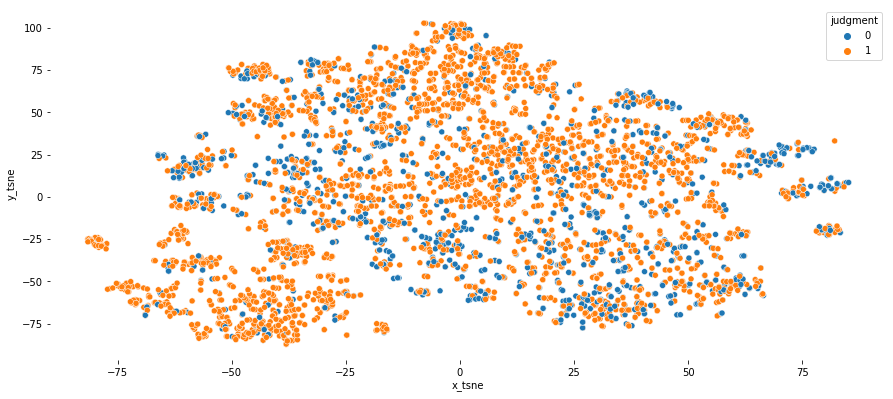

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt

# variables in the dataset
f, ax = plt.subplots(figsize=(15, 6.5))
sns.despine(f, left=True, bottom=True)

sns.scatterplot(
    x="x_tsne", y="y_tsne", hue="judgment", data=embeddingsdf, ax=ax
)

In [84]:
import plotly.express as px

fig = px.scatter(embeddingsdf, x="x_pca", y="y_pca", hover_name="statement", color="reasoning")
fig.update_traces(textposition="top center")
fig.update_layout(
    title="t-SNE Visualization of Embeddings",
    xaxis=dict(title="t-SNE Dimension 1"),
    yaxis=dict(title="t-SNE Dimension 2"),
)
fig.show()

-----------------------
## Making a balanced training and test set

In [21]:
# number of dimentions per category

features = ['behavior', 'everyday', 'judgment', 'opinion', 'reasoning', 'figure_of_speech']
merged_df.groupby('category').count()[features]

,behavior,everyday,judgment,opinion,reasoning,figure_of_speech
category,,,,,,
Culture and the arts,326,326,326,326,326,326
General reference,780,780,780,780,780,780
Geography and places,128,128,128,128,128,128
Health and fitness,266,266,266,266,266,266
History and events,112,112,112,112,112,112
Human activities,622,622,622,622,622,622
Mathematics and logic,93,93,93,93,93,93
Natural and physical sciences,162,162,162,162,162,162
People and self,909,909,909,909,909,909


In [22]:
grouped = merged_df.groupby('category')[features].apply(lambda x: x.apply(pd.Series.value_counts)).unstack().fillna(0)
grouped

behavior      everyday      judgment       \
                                       0    1        0    1        0    1   
category                                                                    
Culture and the arts                 178  148      155  171      146  180   
General reference                    384  396      353  427      257  523   
Geography and places                  86   42       55   73       80   48   
Health and fitness                   135  131      103  163      108  158   
History and events                    60   52       71   41       57   55   
Human activities                     166  456      125  497      142  480   
Mathematics and logic                 49   44       20   73       42   51   
Natural and physical sciences        112   50       47  115      102   60   
People and self                      123  786      195  714      123  786   
Philosophy and thinking               34  288      192  130       40  282   
Religion and belief systems           72   80       96   56       54   98   
Society and social sciences           21  436      196  261       29  428   
Technology and applied sciences       48   30       20   58       36   42   

                                opinion      reasoning      figure_of_speech  \
                                      0    1         0    1                0   
category                                                                       
Culture and the arts                149  177       101  225              234   
General reference                   364  416       317  463              588   
Geography and places                 77   51        66   62              100   
Health and fitness                  134  132       103  163              231   
History and events                   56   56        33   79               76   
Human activities                    220  402       214  408              574   
Mathematics and logic                58   35        58   35               78   
Natural and physical sciences       113   49       101   61              136   
People and self                     212  697       222  687              766   
Philosophy and thinking              54  268       129  193              159   
Religion and belief systems          73   79        63   89              125   
Society and social sciences          46  411       216  241              421   
Technology and applied sciences      46   32        49   29               65   

                                      
                                   1  
category                              
Culture and the arts              92  
General reference                192  
Geography and places              28  
Health and fitness                35  
History and events                36  
Human activities                  48  
Mathematics and logic             15  
Natural and physical sciences     26  
People and self                  143  
Philosophy and thinking          163  
Religion and belief systems       27  
Society and social sciences       36  
Technology and applied sciences   13

In [27]:
for feature in features:
    print(
        feature,
        "- ratio:",
        merged_df[merged_df[feature] == 1].shape[0]
        / merged_df[merged_df[feature] == 0].shape[0],
    )
    print(merged_df[merged_df[feature] == 1].shape[0])
    print(merged_df[merged_df[feature] == 0].shape[0])

behavior - ratio: 2.0020435967302452
2939
1468
everyday - ratio: 1.707002457002457
2779
1628
judgment - ratio: 2.6241776315789473
3191
1216
opinion - ratio: 1.750936329588015
2805
1602
reasoning - ratio: 1.6357655502392345
2735
1672
figure_of_speech - ratio: 0.24036025893611032
854
3553


In [146]:
merged_df[merged_df['behavior'] == 0].shape[0]

1468

In [148]:
def sample_into_buckets(data_list, k, seed):
    random.seed(seed)
    data_copy = list(data_list)
    buckets = [[] for _ in range(k)]
    elements_per_bucket = len(data_list) // k

    for bucket in buckets:
        bucket_data = random.sample(data_copy, elements_per_bucket)
        data_copy = [item for item in data_copy if item not in bucket_data]
        bucket.extend(bucket_data)

    return buckets


balanced_data = {}

k = 10
seed = 42

for feature in features:
    # Given values
    feature_ones_index = merged_df[merged_df[feature] == 1].index.values
    feature_zeros_index = merged_df[merged_df[feature] == 0].index.values

    print(
        feature,
        "number of ones:",
        len(feature_ones_index) // k,
        ", zeros per bucket:",
        len(feature_zeros_index) // k,
        "total bucket size:",
        (len(feature_ones_index) // k) + (len(feature_zeros_index) // k),
    )

    balanced_data[feature] = {}

    # Split into buckets
    feature_ones_buckets = sample_into_buckets(feature_ones_index, k, seed)
    feature_zeros_buckets = sample_into_buckets(feature_zeros_index, k, seed)

    balanced_data[feature]["ones"] = feature_ones_buckets
    balanced_data[feature]["zeros"] = feature_zeros_buckets

behavior number of ones: 293 , zeros per bucket: 146 total bucket size: 439
everyday number of ones: 277 , zeros per bucket: 162 total bucket size: 439
judgment number of ones: 319 , zeros per bucket: 121 total bucket size: 440
opinion number of ones: 280 , zeros per bucket: 160 total bucket size: 440
reasoning number of ones: 273 , zeros per bucket: 167 total bucket size: 440
figure_of_speech number of ones: 85 , zeros per bucket: 355 total bucket size: 440


In [169]:
def get_train_test_split(balanced_data, f, k):
    min_len = min(len(balanced_data[f]["ones"][0]), len(balanced_data[f]["zeros"][0]))
    print(f, min_len)

    buckets = []

    for i in range(k):
        X_test_indexes = balanced_data[f]["ones"][i] + balanced_data[f]["zeros"][i]

        X_train_indexes = []
        for j in range(k):
            if j != i:
                X_train_indexes.extend(
                    random.sample(balanced_data[f]["ones"][j], min_len)
                )
                X_train_indexes.extend(
                    random.sample(balanced_data[f]["zeros"][j], min_len)
                )

        X_train = merged_df.iloc[X_train_indexes]["embeddings"].values
        y_train = merged_df.iloc[X_train_indexes][f].values

        X_test = merged_df.iloc[X_test_indexes]["embeddings"].values
        y_test = merged_df.iloc[X_test_indexes][f].values

        # print('X_train', X_train.shape, 'y_train', y_train.shape, 'X_test', X_test.shape, 'y_test', y_test.shape)

        buckets.append(((X_train, y_train), (X_test, y_test)))

    return buckets

# Assuming you have 'merged_df' and 'balanced_data' defined somewhere
k = 10
gg = get_train_test_split(balanced_data, 'behavior', k)




behavior 146


In [170]:
X_train, y_train = gg[0][0]
X_test, y_test = gg[0][1]

print(len(X_train), len(y_train))
print(len(X_test), len(y_test))


2628 2628
439 439


In [ ]:
result_metrics = []

for f in features:
    # print(f)
    gg = get_train_test_split(balanced_data, f, k)
    rf = RandomForestClassifier()
    for i in range(10):
        X_train, y_train = gg[i][0]
        X_test, y_test = gg[i][1]

        rf.fit(list(X_train), y_train)
        y_pred = rf.predict(list(X_test))
        accuracy = jaccard_score(y_test, y_pred)
        print(
            "fold:",
            i + 1,
            ", f1: ",
            f1_score(y_test, y_pred),
            ", Accuracy: ",
            accuracy,
            ", r-squared:",
            do_global_r_sqaured(y_test, y_pred, verbose=False),
        )

        result_metrics.append(
            {
                'method': 'random-forest',
                "feature": f,
                "accuracy": accuracy,
                "f1": f1_score(y_test, y_pred),
                "r-squared": do_global_r_sqaured(y_test, y_pred, verbose=False),
            }
        )

In [184]:
print(pd.DataFrame(result_metrics).groupby('feature').mean().to_markdown())

| feature          |   accuracy |       f1 |   r-squared |
|:-----------------|-----------:|---------:|------------:|
| behavior         |   0.57099  | 0.726544 |    0.514334 |
| everyday         |   0.498711 | 0.665319 |    0.425993 |
| figure_of_speech |   0.304055 | 0.465789 |   -0.456471 |
| judgment         |   0.541497 | 0.702167 |    0.490909 |
| opinion          |   0.552609 | 0.711658 |    0.476071 |
| reasoning        |   0.461851 | 0.631073 |    0.39304  |


In [186]:
xgb_metrics = []

for f in features:
    # print(f)
    gg = get_train_test_split(balanced_data, f, k)

    params = {"objective": "binary:logistic", "max_depth": 3, "learning_rate": 0.1}

    n = 100

    for i in range(10):
        X_train, y_train = gg[i][0]
        X_test, y_test = gg[i][1]

        dtrain = xgb.DMatrix(np.vstack(X_train), label=y_train, enable_categorical=True)
        dtest = xgb.DMatrix(np.vstack(X_test), label=y_test, enable_categorical=True)

        model = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=n,
        )

        preds = model.predict(dtest)

        print(
            "fold:",
            i + 1,
            ", f1: ",
            f1_score(y_test, (preds > 0.5).astype(int)),
            ", Accuracy: ",
            jaccard_score(y_test, (preds > 0.5).astype(int)),
            ", r-squared:",
            do_global_r_sqaured(y_test, preds, verbose=False),
        )

        xgb_metrics.append(
            {
                'method': 'xgboost',
                "feature": f,
                "accuracy": jaccard_score(y_test, (preds > 0.5).astype(int)),
                "f1": f1_score(y_test, (preds > 0.5).astype(int)),
                "r-squared": do_global_r_sqaured(y_test, preds, verbose=False),
            }
        )

behavior 146
fold: 1 , f1:  0.7262357414448669 , Accuracy:  0.5701492537313433 , r-squared: 0.7034893211654213
fold: 2 , f1:  0.7132075471698114 , Accuracy:  0.5542521994134897 , r-squared: 0.6759714466183004
fold: 3 , f1:  0.7646017699115044 , Accuracy:  0.6189111747851003 , r-squared: 0.6981912955209937
fold: 4 , f1:  0.7350746268656716 , Accuracy:  0.5811209439528023 , r-squared: 0.6830814480492065
fold: 5 , f1:  0.7462686567164178 , Accuracy:  0.5952380952380952 , r-squared: 0.6979016440881309
fold: 6 , f1:  0.7102803738317757 , Accuracy:  0.5507246376811594 , r-squared: 0.6625785185320823
fold: 7 , f1:  0.72265625 , Accuracy:  0.5657492354740061 , r-squared: 0.6840513552901557
fold: 8 , f1:  0.752808988764045 , Accuracy:  0.6036036036036037 , r-squared: 0.6952199917479673
fold: 9 , f1:  0.7745454545454545 , Accuracy:  0.6320474777448071 , r-squared: 0.7095911769088953
fold: 10 , f1:  0.7545126353790614 , Accuracy:  0.6057971014492753 , r-squared: 0.6969594397615811
everyday 162
fo

In [190]:
pd.concat([pd.DataFrame(result_metrics), pd.DataFrame(xgb_metrics)]).groupby(
    ["method", "feature"]
).mean()

accuracy        f1  r-squared
method        feature                                        
random-forest behavior          0.570990  0.726544   0.514334
              everyday          0.498711  0.665319   0.425993
              figure_of_speech  0.304055  0.465789  -0.456471
              judgment          0.541497  0.702167   0.490909
              opinion           0.552609  0.711658   0.476071
              reasoning         0.461851  0.631073   0.393040
xgboost       behavior          0.587759  0.740019   0.690704
              everyday          0.522151  0.685805   0.656176
              figure_of_speech  0.295346  0.455153  -0.053143
              judgment          0.563239  0.720369   0.694795
              opinion           0.569915  0.725876   0.670690
              reasoning         0.501290  0.667130   0.650221

In [30]:
embeddings = np.vstack(merged_df.embeddings.values)

similarity = np.dot(embeddings, embeddings.T)

# squared magnitude of preference vectors (number of occurrences)
square_mag = np.diag(similarity)

# inverse squared magnitude
inv_square_mag = 1 / square_mag

# if it doesn't occur, set it's inverse magnitude to zero (instead of inf)
inv_square_mag[np.isinf(inv_square_mag)] = 0

# inverse of the magnitude
inv_mag = np.sqrt(inv_square_mag)

# cosine similarity (elementwise multiply by inverse magnitudes)
cosine = similarity * inv_mag
cosine = cosine.T * inv_mag

cosine[np.diag_indices_from(cosine)] = 0

cosine_similarity_df = pd.DataFrame(cosine)

In [38]:
behavior_0 = merged_df[merged_df.behavior == 0].index.values
behavior_1 = merged_df[merged_df.behavior == 1].index.values


In [49]:
embed_df = cosine_similarity_df.iloc[behavior_0, behavior_1]

In [45]:
embed_df['max'] = embed_df.idxmax(axis=1)
embed_df

,2,6,7,8,9,15,16,20,21,22,...,4393,4394,4395,4396,4397,4399,4403,4404,4405,max
0,0.768858,0.734954,0.755663,0.745837,0.737133,0.726766,0.733851,0.742053,0.736662,0.765123,...,0.736407,0.737304,0.737768,0.745722,0.734942,0.749978,0.755869,0.750632,0.891797,3749
1,0.746877,0.720330,0.726464,0.730601,0.741016,0.717869,0.731849,0.736922,0.717359,0.727019,...,0.727387,0.717010,0.720432,0.710536,0.702584,0.718837,0.732121,0.739030,0.789915,74
3,0.762360,0.738051,0.761603,0.738683,0.753654,0.747160,0.740396,0.754753,0.748806,0.729490,...,0.753492,0.744591,0.744089,0.721286,0.718522,0.718880,0.738609,0.731913,0.764266,75
4,0.728369,0.749691,0.766164,0.747815,0.706825,0.749171,0.778536,0.743873,0.755026,0.763199,...,0.752963,0.739904,0.742767,0.729687,0.731823,0.730893,0.706421,0.706442,0.714313,84
5,0.756022,0.726581,0.742632,0.744050,0.708133,0.715834,0.713784,0.731860,0.737021,0.688135,...,0.725639,0.715683,0.717478,0.728731,0.710908,0.728621,0.732304,0.724411,0.721518,311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4398,0.878313,0.711430,0.748316,0.750400,0.726001,0.721053,0.726559,0.861356,0.724224,0.723191,...,0.858254,0.761350,0.767193,0.777074,0.760428,0.746437,0.742947,0.737542,0.732476,524
4400,0.723161,0.708898,0.731235,0.714043,0.712824,0.752874,0.706613,0.741154,0.713476,0.719501,...,0.724455,0.740516,0.738029,0.734349,0.732597,0.833719,0.788531,0.746793,0.744018,3534
4401,0.740123,0.705420,0.731587,0.720857,0.703402,0.708033,0.763938,0.758030,0.711087,0.727117,...,0.741670,0.717278,0.714961,0.693791,0.691140,0.712439,0.698484,0.705173,0.721591,4144
4402,0.751091,0.727155,0.740499,0.739951,0.715504,0.729898,0.760748,0.771197,0.715718,0.733847,...,0.710510,0.706118,0.711573,0.714283,0.702066,0.750724,0.748390,0.742430,0.721627,2879


In [56]:
max_indices = []

for index, row in embed_df.head(5).iterrows():
    max_column = row.idxmax()
    max_indices.append((index, max_column))


for (i_1, i_2) in max_indices:
    print(i_1, i_2)
    print(merged_df.iloc[i_1].statement_x)
    print(merged_df.iloc[i_2].statement_x)
    print('---------------')


0 3749
1 plus 1 is 2
two times two is four
---------------
1 74
5 is alot bigger than 1
a number raised to another number is generally higher than the addition of those two numbers
---------------
3 75
a ball is round
a one and a one make an eleven
---------------
4 84
a baton twirler doesn't want a broken finger
a person doesn't want a hangnail
---------------
5 311
a battery can't provide power forever
beyond a certain point there is no return this point has to be reached
---------------


-------------------------
## Random Forest Classifier

Spliting the data into train and test sets then run random forest

In [85]:
for category in merged_df['category'].unique():
    X_train = merged_df[merged_df['category'] != category].embeddings
    y_train = merged_df[merged_df['category'] != category].behavior

    X_test = merged_df[merged_df['category'] == category].embeddings.to_numpy()
    y_test = merged_df[merged_df['category'] == category].behavior.to_numpy()

    rf = RandomForestClassifier()
    rf.fit(list(X_train), y_train)
    y_pred = rf.predict(list(X_test))
    accuracy = jaccard_score(y_test, y_pred)
    print(category, " Accuracy: ", accuracy)

Mathematics and logic  Accuracy:  0.6451612903225806
Health and fitness  Accuracy:  0.6578947368421053
Natural and physical sciences  Accuracy:  0.6666666666666666
Human activities  Accuracy:  0.747588424437299
General reference  Accuracy:  0.5884615384615385
Religion and belief systems  Accuracy:  0.5986842105263158
People and self  Accuracy:  0.8063806380638063
Technology and applied sciences  Accuracy:  0.5128205128205128
Society and social sciences  Accuracy:  0.9474835886214442
History and events  Accuracy:  0.5267857142857143
Philosophy and thinking  Accuracy:  0.8633540372670807
Culture and the arts  Accuracy:  0.5276073619631901
Geography and places  Accuracy:  0.5390625


In [159]:
def do_global_r_sqaured(actual_values, model_predictions, verbose=True):
    # Calculate MSE for model and baseline
    baseline_predictions = [mean(actual_values)] * len(actual_values)
    mse_model = mean_squared_error(actual_values, model_predictions)
    mse_baseline = mean_squared_error(actual_values, baseline_predictions)

    # Calculate Global R-squared
    global_r_squared = 1 - (mse_model / mse_baseline)

    if verbose:
        print(f'Mean Squared Error (Model): {mse_model}')
        print(f'Mean Squared Error (Baseline): {mse_baseline}')
        print(f'Global R-squared: {global_r_squared}')

    return global_r_squared

In [54]:


outcomes = ['behavior', 'everyday', 'figure_of_speech', 'judgment', 'opinion', 'reasoning']

for outcome in outcomes:
    X_train = merged_df[merged_df['category'] != 'Society and social sciences'].embeddings
    y_train = merged_df[merged_df['category'] != 'Society and social sciences'][outcome]

    X_test = merged_df[merged_df['category'] == 'Society and social sciences'].embeddings
    y_test = merged_df[merged_df['category'] == 'Society and social sciences'][outcome]

    rf = RandomForestClassifier()
    rf.fit(list(X_train), y_train)
    y_pred = rf.predict(list(X_test))
    accuracy = jaccard_score(y_test, y_pred)
    print(outcome, "- Accuracy:", accuracy)
    print("F1 score:", f1_score(y_test, y_pred))
    do_global_r_sqaured(y_test, y_pred)
    print('----------------------------')

behavior - Accuracy: 0.9340659340659341
F1 score: 0.9659090909090909
Mean Squared Error (Model): 0.06564551422319474
Mean Squared Error (Baseline): 0.04384028652279878
Global R-squared: -0.49737876802096914
----------------------------
everyday - Accuracy: 0.5113350125944585
F1 score: 0.6766666666666666
Mean Squared Error (Model): 0.424507658643326
Mean Squared Error (Baseline): 0.24494251827875638
Global R-squared: -0.7330909375244352
----------------------------
figure_of_speech - Accuracy: 0.027777777777777776
F1 score: 0.05405405405405406
Mean Squared Error (Model): 0.07658643326039387
Mean Squared Error (Baseline): 0.07256917677364984
Global R-squared: -0.0553576141462131
----------------------------
judgment - Accuracy: 0.9385964912280702
F1 score: 0.9683257918552036
Mean Squared Error (Model): 0.061269146608315096
Mean Squared Error (Baseline): 0.059430497632260604
Global R-squared: -0.03093780212697439
----------------------------
opinion - Accuracy: 0.8913525498891353
F1 score

## XGBoost

In [58]:

for outcome in outcomes:
    X_train = merged_df[merged_df['category'] != 'Society and social sciences'].embeddings.to_numpy()
    y_train = merged_df[merged_df['category'] != 'Society and social sciences'][outcome]

    X_test = merged_df[merged_df['category'] == 'Society and social sciences'].embeddings
    y_test = merged_df[merged_df['category'] == 'Society and social sciences'][outcome]

    dtrain = xgb.DMatrix(np.vstack(X_train), label=y_train, enable_categorical=True)
    dtest = xgb.DMatrix(np.vstack(X_test), label=y_test, enable_categorical=True)
    
    params = {
        "objective": "binary:logistic",
        "max_depth": 3,  
        "learning_rate": 0.1
    }

    n = 100

    model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=n,
    )

    preds = model.predict(dtest)

    print(outcome)
    print("F1 score:", f1_score(y_test, (preds > 0.5).astype(int)))
    do_global_r_sqaured(y_test, preds)
    print('----------------------------')

behavior
F1 score: 0.9501738122827347
Mean Squared Error (Model): 0.11371604070025852
Mean Squared Error (Baseline): 0.04384028652279878
Global R-squared: -1.5938708370694936
----------------------------
everyday
F1 score: 0.6736111111111112
Mean Squared Error (Model): 0.22471228478066843
Mean Squared Error (Baseline): 0.24494251827875638
Global R-squared: 0.082591759243142
----------------------------
figure_of_speech
F1 score: 0.1818181818181818
Mean Squared Error (Model): 0.06647939092147037
Mean Squared Error (Baseline): 0.07256917677364984
Global R-squared: 0.08391697581431967
----------------------------
judgment
F1 score: 0.9634703196347033
Mean Squared Error (Model): 0.09436104483931075
Mean Squared Error (Baseline): 0.059430497632260604
Global R-squared: -0.5877545805386093
----------------------------
opinion
F1 score: 0.9403341288782817
Mean Squared Error (Model): 0.11335814963327051
Mean Squared Error (Baseline): 0.09052473318043179
Global R-squared: -0.2522340099840745
---

In [45]:
# Define hyperparameters
params = {
    "objective": "binary:logistic",
    "max_depth": 3,  
    "learning_rate": 0.1
}

n = 100

model = xgb.train(
   params=params,
   dtrain=dtrain,
   num_boost_round=n,
)

preds = model.predict(dtest)

do_global_r_sqaured(y_test, preds)

In [46]:
preds

array([0.5513926 , 0.63500744, 0.8711003 , 0.9280181 , 0.7691742 ,
       0.5081068 , 0.6342565 , 0.69798386, 0.70887953, 0.76032114,
       0.7780644 , 0.67430806, 0.7777077 , 0.72518116, 0.6964074 ,
       0.56942475, 0.783343  , 0.5788355 , 0.55333483, 0.7435953 ,
       0.765805  , 0.7316966 , 0.6351676 , 0.7332892 , 0.675165  ,
       0.53415906, 0.3778532 , 0.6251968 , 0.5572829 , 0.7151871 ,
       0.6123967 , 0.74304515, 0.67549264, 0.65214986, 0.545905  ,
       0.78630805, 0.72232753, 0.5149935 , 0.6753522 , 0.83459884,
       0.48986483, 0.60221285, 0.74860305, 0.714236  , 0.7745888 ,
       0.42819548, 0.42683434, 0.84305006, 0.44031626, 0.728522  ,
       0.75557184, 0.6138055 , 0.7969557 , 0.60070235, 0.7167251 ,
       0.5629116 , 0.70209384, 0.89316744, 0.6994382 , 0.81649363,
       0.5754485 , 0.5432339 , 0.76022977, 0.72770417, 0.92340726,
       0.77325565, 0.6427894 , 0.75400263, 0.64704955, 0.50671095,
       0.5590861 , 0.71225184, 0.54473853, 0.7751772 , 0.93819

In [47]:
do_global_r_sqaured(y_test, preds)

Mean Squared Error (Model): 0.11371604070025852
Mean Squared Error (Baseline): 0.045951859956236324
Global R-squared: -1.4746776476199117


In [46]:
def label_statement(statement):
    response = openai.ChatCompletion.create(
        model="gpt-4",
        messages=[
            {
                "role": "system",
                "content": 'You are a bot that take a statement from user and give the properties of the statement based on the following definitions, don\'t explain your answer and answer in JSON format ({\n"behavior": ,\n"everyday":,\n"figure_of_speech",\n"judgment":,\n"opinion":,\n"reasoning":,\n"knowledge category": \n}). Dimensions of statement and their definition:\nIs it behavior?\nyest: it refers to beliefs, perceptions, preferences, and socially con-structed rules that govern human experience; it can be “real” or opinion, but is intrinsically of human origins. e.g., I exist and am the same person I was yesterday. He yelled at me because he was angry. There are seven days in the week.\nno: it refers to objective features of the world as described by, say, physics, biology, engineering, mathematics or other natural rules; it can be measured empirically, or derived logically. e.g., Men on average are taller than women. The Earth is the third planet from the Sun. Ants are smaller than Elephants.\n\nIs it everyday?\nyes: people encounter, or could encounter, situations like this in the course of their ordinary, everyday experiences, e.g., Touching a hot stove will burn you. Commuting at rush hour takes longer. It is rude to jump the line.\nno: this claim refers to regularities or conclusions that cannot be observed or arrived at solely through individual experience, e.g., Capitalism is a better economic system than Communism. Strict gun laws save lives. God exists\n\nIs it figure_of_speech?\nyes: it contains an aphorism, metaphor, hyperbole, e.g., Birds of a feather flock together. A friend to all is a friend to none.\nno: it is plain and ordinary language that means exactly what it says. e.g. The sky is blue. Elephants are larger than dogs. Abraham Lincoln was a great president.\n\nis it judgment?\nyes: it refers to a judgment, belief, value, social norm or convention. e.g., If you are going to the office, you should wear business attire,not a bathing suit. Treat others how you want them to treat you. Freedom is a fundamental human right.\nno: it refers to something in the world such as an empirical regularity or scientific law, e.g., hot things will burn you; the sun rises in the east and sets in the west.\n\nIs it opinion?\nyes: it is something that someone might think is true, or wants others to think is true, but can’t be demonstrated to be objectively correct or incorrect; it is inherently subjective. e.g., FDR was the greatest US president of the 20th Century.. The Brooklyn Bridge is prettier than the Golden Gate. Vaccine mandates are a tolerable imposition on individual freedom.\nno: it is something that can be demonstrated to be correct or incorrect, independently of anyone’s opinion, e.g., the earth is the third planet from the sun (this is correct and we know it is correct), Obama was the 24th president of the United States (this is incorrect, but we know it’s incorrect). It will be sunny next Tuesday (we don’t yet know if this is correct, but we will be able to check in the future).\n\nIs it reasoning?\nyes: the claim presents a conclusion that is arrived at by combining knowledge and logic, e.g., The sun is in the east, therefore it is morning. My dog is wagging its tail, therefore it is happy. The glass fell off the table, therefore it will break and the floor will become wet.\nno: the claim refers to some observation about the world; it may be true or false, opinion or fact, subjective or objective e.g., The sun rises in the east and sets in the west. Dogs are nicer than cats. Glasses break when they are dropped.\n\nWhich knowledge category or categories describe this claim? (choose one that apply)\n    General reference\n    Culture and the arts\n    Geography and places\n    Health and fitness\n    History and events\n    Human activities\n    Mathematics and logic\n    Natural and physical sciences\n    People and self\n    Philosophy and thinking\n    Religion and belief systems\n    Society and social sciences\n    Technology and applied sciences\n',
            },
            {
                "role": "user",
                "content": statement,
            },
        ],
        temperature=0,
        max_tokens=256,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
    )

    return response

In [72]:
first_500_statements = []

for s in merged_df['statement_y'].head(500).values:
    first_500_statements.append(label_statement(s))

In [85]:
df_data = []

for _ in first_500_statements:
    df_data.append(json.loads(_['choices'][0]['message']['content']))

df_0_to_500 = pd.DataFrame(df_data)
df_0_to_500['statement_index'] = df_0_to_500.index + 1
df_0_to_500

,behavior,everyday,figure_of_speech,judgment,opinion,reasoning,knowledge category,statement_index
0,no,yes,no,no,no,no,Mathematics and logic,1
1,no,yes,no,no,no,no,Mathematics and logic,2
2,no,yes,no,yes,no,no,Health and fitness,3
3,no,yes,no,no,no,no,Natural and physical sciences,4
4,yes,yes,no,yes,no,no,Human activities,5
...,...,...,...,...,...,...,...,...
95,yes,yes,no,yes,yes,no,People and self,96
96,yes,yes,no,yes,yes,no,People and self,97
97,yes,yes,no,yes,yes,no,People and self,98
98,yes,yes,no,yes,yes,no,Human activities,99


In [100]:
fivehundred_1000_statements = []

for s in tqdm(merged_df['statement_y'].values[500:1000]):
    fivehundred_1000_statements.append(label_statement(s))

100%|██████████| 500/500 [28:00<00:00,  3.36s/it]


In [104]:
df_data = []

for _ in fivehundred_1000_statements:
    df_data.append(json.loads(_['choices'][0]['message']['content']))

df_500_to_1000 = pd.DataFrame(df_data)
df_500_to_1000['statement_index'] = df_500_to_1000.index + 501
df_500_to_1000


,behavior,everyday,figure_of_speech,judgment,opinion,reasoning,knowledge category,statement_index
0,no,yes,yes,no,no,no,Natural and physical sciences,501
1,yes,no,no,yes,yes,no,Culture and the arts,502
2,yes,no,no,yes,yes,no,Society and social sciences,503
3,yes,yes,no,yes,yes,no,Philosophy and thinking,504
4,yes,yes,no,yes,yes,no,Religion and belief systems,505
...,...,...,...,...,...,...,...,...
495,yes,yes,no,yes,yes,no,Human activities,996
496,yes,no,yes,yes,yes,yes,Human activities,997
497,yes,yes,no,yes,yes,no,Human activities,998
498,yes,yes,no,yes,yes,yes,Human activities,999


In [114]:
thousand_1500_statements = []

for s in tqdm(merged_df['statement_y'].values[1000:1500]):
    thousand_1500_statements.append(label_statement(s))

100%|██████████| 365/365 [21:43<00:00,  3.57s/it]


In [115]:
df_data = []

for _ in thousand_1500_statements:
    df_data.append(json.loads(_['choices'][0]['message']['content']))

df_1000_to_1500 = pd.DataFrame(df_data)
df_1000_to_1500['statement_index'] = df_1000_to_1500.index + 1001
df_1000_to_1500


,behavior,everyday,figure_of_speech,judgment,opinion,reasoning,knowledge category,statement_index
0,yes,yes,no,no,no,no,Human activities,1001
1,no,yes,no,no,no,yes,People and self,1002
2,no,yes,no,no,no,yes,Human activities,1003
3,yes,yes,no,yes,yes,yes,Human activities,1004
4,yes,yes,no,yes,yes,yes,People and self,1005
...,...,...,...,...,...,...,...,...
495,yes,yes,no,no,no,yes,Health and fitness,1496
496,yes,yes,no,yes,yes,yes,Human activities,1497
497,yes,yes,no,no,yes,yes,Society and social sciences,1498
498,yes,yes,no,yes,yes,no,Human activities,1499


In [117]:
thousandfive_2000_statements = []

for s in tqdm(merged_df['statement_y'].values[1500:2000]):
    thousandfive_2000_statements.append(label_statement(s))

100%|██████████| 500/500 [28:24<00:00,  3.41s/it]


In [118]:
df_data = []

for _ in thousandfive_2000_statements:
    df_data.append(json.loads(_['choices'][0]['message']['content']))

df_1500_to_2000 = pd.DataFrame(df_data)
df_1500_to_2000['statement_index'] = df_1500_to_2000.index + 1501
df_1500_to_2000


,behavior,everyday,figure_of_speech,judgment,opinion,reasoning,knowledge category,statement_index
0,yes,no,no,yes,yes,yes,Society and social sciences,1501
1,yes,yes,no,no,no,yes,Human activities,1502
2,yes,yes,no,no,no,yes,Human activities,1503
3,yes,yes,no,yes,yes,yes,Human activities,1504
4,yes,yes,no,yes,yes,no,Health and fitness,1505
...,...,...,...,...,...,...,...,...
495,yes,yes,no,yes,yes,yes,People and self,1996
496,yes,yes,no,yes,yes,yes,People and self,1997
497,yes,yes,no,yes,yes,yes,Human activities,1998
498,yes,yes,no,yes,yes,yes,People and self,1999


In [122]:
rating_df = pd.concat([df_0_to_500, df_500_to_1000, df_1000_to_1500, df_1500_to_2000], axis=0).reset_index(drop=True)
rating_df.head(5)

,behavior,everyday,figure_of_speech,judgment,opinion,reasoning,knowledge category,statement_index
0,no,yes,no,no,no,no,Mathematics and logic,1
1,no,yes,no,no,no,no,Mathematics and logic,2
2,no,yes,no,yes,no,no,Health and fitness,3
3,no,yes,no,no,no,no,Natural and physical sciences,4
4,yes,yes,no,yes,no,no,Human activities,5


In [23]:
# assuming the dataframe is named "df"
new_columns = {}
for col in rating_df.columns:
    if col != "statement_index":
        new_columns[col] = f"gpt_{col}"

gpt_rating_df = rating_df.rename(columns=new_columns)


NameError: name 'rating_df' is not defined

In [47]:

# gpt_rating_df = pd.concat([merged_df.head(2000), gpt_rating_df], axis=1)
for col in ['gpt_behavior', 'gpt_everyday', 'gpt_figure_of_speech', 'gpt_judgment', 'gpt_opinion', 'gpt_reasoning']:
    gpt_rating_df[col] = gpt_rating_df[col].replace({'yes': 1, 'no': 0})


In [50]:
outcomes = ['behavior', 'everyday', 'figure_of_speech', 'judgment', 'opinion', 'reasoning']

for o in outcomes:
    print(o)
    do_global_r_sqaured(gpt_rating_df[o].values, gpt_rating_df[f'gpt_{o}'].values)

behavior
Mean Squared Error (Model): 0.3225
Mean Squared Error (Baseline): 0.643
Global R-squared: 0.4984447900466563
everyday
Mean Squared Error (Model): 0.323
Mean Squared Error (Baseline): 0.658
Global R-squared: 0.5091185410334347
figure_of_speech
Mean Squared Error (Model): 0.1665
Mean Squared Error (Baseline): 0.186
Global R-squared: 0.10483870967741926
judgment
Mean Squared Error (Model): 0.3295
Mean Squared Error (Baseline): 0.6995
Global R-squared: 0.5289492494639028
opinion
Mean Squared Error (Model): 0.314
Mean Squared Error (Baseline): 0.624
Global R-squared: 0.4967948717948718
reasoning
Mean Squared Error (Model): 0.3035
Mean Squared Error (Baseline): 0.731
Global R-squared: 0.5848153214774282


In [139]:
do_global_r_sqaured(gpt_rating_df.behavior.values, gpt_rating_df.gpt_behavior.values)

Mean Squared Error (Model): 0.3225
Mean Squared Error (Baseline): 0.357
Global R-squared: 0.09663865546218486


In [41]:
gpt_rating_df = pd.read_pickle('rating_df.pkl')
outcomes = ['behavior', 'everyday', 'figure_of_speech', 'judgment', 'opinion', 'reasoning']

new_columns = {}
for col in outcomes:
    if col != "statement_index":
        new_columns[col] = f"gpt_{col}"

gpt_rating_df = gpt_rating_df.rename(columns=new_columns)
gpt_rating_df

,gpt_behavior,gpt_everyday,gpt_figure_of_speech,gpt_judgment,gpt_opinion,gpt_reasoning,knowledge category,statement_index
0,no,yes,no,no,no,no,Mathematics and logic,1
1,no,yes,no,no,no,no,Mathematics and logic,2
2,no,yes,no,yes,no,no,Health and fitness,3
3,no,yes,no,no,no,no,Natural and physical sciences,4
4,yes,yes,no,yes,no,no,Human activities,5
...,...,...,...,...,...,...,...,...
1995,yes,yes,no,yes,yes,yes,People and self,1996
1996,yes,yes,no,yes,yes,yes,People and self,1997
1997,yes,yes,no,yes,yes,yes,Human activities,1998
1998,yes,yes,no,yes,yes,yes,People and self,1999


In [30]:
gpt_rating_df

,gpt_behavior,gpt_everyday,gpt_figure_of_speech,gpt_judgment,gpt_opinion,gpt_reasoning,knowledge category,statement_index
0,0,1,0,0,0,0,Mathematics and logic,1
1,0,1,0,0,0,0,Mathematics and logic,2
2,0,1,0,1,0,0,Health and fitness,3
3,0,1,0,0,0,0,Natural and physical sciences,4
4,1,1,0,1,0,0,Human activities,5
...,...,...,...,...,...,...,...,...
1995,1,1,0,1,1,1,People and self,1996
1996,1,1,0,1,1,1,People and self,1997
1997,1,1,0,1,1,1,Human activities,1998
1998,1,1,0,1,1,1,People and self,1999


In [44]:
gpt_rating_df = pd.concat([merged_df.head(2000), gpt_rating_df], axis=1)
gpt_rating_df

,statement_number,statement_x,behavior,everyday,figure_of_speech,judgment,opinion,reasoning,category,elicitation,...,fixed statement,embeddings,gpt_behavior,gpt_everyday,gpt_figure_of_speech,gpt_judgment,gpt_opinion,gpt_reasoning,knowledge category,statement_index
0,1,1 plus 1 is 2,0,1,0,0,0,1,Mathematics and logic,category response,...,1 plus 1 equals 2.,"[0.030643712729215622, -0.004393580369651318, ...",no,yes,no,no,no,no,Mathematics and logic,1
1,2,5 is alot bigger than 1,0,0,0,0,0,0,Mathematics and logic,category response,...,5 is significantly larger than 1.,"[-9.93039648164995e-05, 0.01369649637490511, 0...",no,yes,no,no,no,no,Mathematics and logic,2
2,3,a balanced diet and regular exercise is needed...,1,1,0,1,0,1,Health and fitness,category response,...,"To maintain good health, one needs a balanced ...","[0.011200563050806522, 0.004698386415839195, 0...",no,yes,no,yes,no,no,Health and fitness,3
3,4,a ball is round,0,1,0,0,0,0,Natural and physical sciences,Concept Net,...,A ball is round.,"[-0.004033376462757587, -4.661796992877498e-05...",no,yes,no,no,no,no,Natural and physical sciences,4
4,5,a baton twirler doesn't want a broken finger,0,1,0,1,1,0,Human activities,Concept Net,...,A baton twirler wouldn't want to suffer a brok...,"[-0.02298833057284355, 0.006554496940225363, 0...",yes,yes,no,yes,no,no,Human activities,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1996,if max acts quickly then max feels anxious,1,1,0,1,1,1,People and self,Atomic,...,"If Max acts quickly, then Max feels anxious.","[-0.029689982533454895, 0.001490147435106337, ...",yes,yes,no,yes,yes,yes,People and self,1996
1996,1997,if max acts quickly then max feels excited,1,1,0,1,1,1,People and self,Atomic,...,"If Max acts quickly, then Max feels excited.","[-0.02703157812356949, -0.006411164533346891, ...",yes,yes,no,yes,yes,yes,People and self,1997
1997,1998,if max acts strange then max is stared at,1,1,0,1,1,1,Society and social sciences,Atomic,...,"If Max acts strangely, then Max gets stared at.","[-0.01861030049622059, 0.0010045332601293921, ...",yes,yes,no,yes,yes,yes,Human activities,1998
1998,1999,if max acts strange then max wants to feel unique,1,1,0,1,1,1,People and self,Atomic,...,"If Max acts strangely, then Max wants to feel ...","[-0.020343828946352005, 0.0069650388322770596,...",yes,yes,no,yes,yes,yes,People and self,1999


In [48]:
do_global_r_sqaured(gpt_rating_df.behavior.values, gpt_rating_df.gpt_behavior.values)

Mean Squared Error (Model): 0.3225
Mean Squared Error (Baseline): 0.643
Global R-squared: 0.4984447900466563


In [45]:
gpt_rating_df.columns

Index(['statement_number', 'statement_x', 'behavior', 'everyday',
       'figure_of_speech', 'judgment', 'opinion', 'reasoning', 'category',
       'elicitation', 'statement_y', 'fixed statement', 'embeddings',
       'gpt_behavior', 'gpt_everyday', 'gpt_figure_of_speech', 'gpt_judgment',
       'gpt_opinion', 'gpt_reasoning', 'knowledge category',
       'statement_index'],
      dtype='object')

In [59]:

outcomes = ['behavior', 'everyday', 'figure_of_speech', 'judgment', 'opinion', 'reasoning']

for o in outcomes:
    print(o)
    print("F1 score:", f1_score(gpt_rating_df[o].values, gpt_rating_df[f'gpt_{o}'].values))
    do_global_r_sqaured(gpt_rating_df[o].values, gpt_rating_df[f'gpt_{o}'].values)



behavior
F1 score: 0.7943895441504623
Mean Squared Error (Model): 0.3225
Mean Squared Error (Baseline): 0.643
Global R-squared: 0.4984447900466563
everyday
F1 score: 0.7906675307841867
Mean Squared Error (Model): 0.323
Mean Squared Error (Baseline): 0.658
Global R-squared: 0.5091185410334347
figure_of_speech
F1 score: 0.40215439856373436
Mean Squared Error (Model): 0.1665
Mean Squared Error (Baseline): 0.186
Global R-squared: 0.10483870967741926
judgment
F1 score: 0.7715771230502599
Mean Squared Error (Model): 0.3295
Mean Squared Error (Baseline): 0.6995
Global R-squared: 0.5289492494639028
opinion
F1 score: 0.769287288758266
Mean Squared Error (Model): 0.314
Mean Squared Error (Baseline): 0.624
Global R-squared: 0.4967948717948718
reasoning
F1 score: 0.7757665312153674
Mean Squared Error (Model): 0.3035
Mean Squared Error (Baseline): 0.731
Global R-squared: 0.5848153214774282
